In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [70]:
df = pd.read_excel('df_cinema_without.xlsx')

In [71]:
films = pd.read_excel('prem_year.xlsx')

In [72]:
#Оставим в датасете только фильмы
df = df[df['movie_name'].isin(films['movie_name'])]

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511636 entries, 0 to 525270
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             511636 non-null  int64         
 1   order_id               511636 non-null  int64         
 2   creation_date          511636 non-null  datetime64[ns]
 3   session_date           511636 non-null  datetime64[ns]
 4   movie_id               511636 non-null  int64         
 5   movie_name             511636 non-null  object        
 6   movie_duration         508374 non-null  object        
 7   movie_age_restriction  510936 non-null  object        
 8   movie_rating           511636 non-null  float64       
 9   number_of_tickets      511636 non-null  int64         
 10  places                 511636 non-null  object        
 11  sales_in_cu            511636 non-null  float64       
 12  ticket_price_in_cu     511636 non-null  floa

## Анализ по теме исследования

In [74]:
#Присоединение колонки дня недели премьеры, дня премьеры, количества билетов на фильм
unique = df.sort_values(by=['session_date','movie_name']).drop_duplicates(subset='movie_name')
unique = unique.assign(prem_day = lambda x: x['session_date'].dt.day_name())
unique = unique.assign(prem_day_of_month = lambda x: x['session_date'].dt.day)
unique = unique[['movie_name','prem_day','prem_day_of_month','session_date']]
unique = unique.rename(columns={'session_date':'premier_date'})

unique  = unique.merge(df.groupby('movie_name').count()['order_id'].reset_index().rename(columns={'order_id':'ticks_count'}), how='inner', on='movie_name')
unique.sort_values(by='ticks_count')

df = df.merge(unique, on='movie_name',how='inner')

In [75]:
#распределение фильмов по категориям
d2 = {}  # фильм: кассовый сбор
s = set()
for i, data in df.iterrows():
    film = data['movie_name']
    d2[film] = d2.get(film, 0) + data['sales_in_cu']
a = []
for i in d2:
    a += [[i, d2[i]]]
groups = pd.DataFrame(a, columns =['movie_name', 'sum_profit'])
groups['success'] = np.nan * len(groups)
quantile_25 = groups.sum_profit.quantile(q=0.25)
quantile_75 = groups.sum_profit.quantile(q=0.75)
quantile_99 = groups.sum_profit.quantile(q=0.99)
for i, data in groups.iterrows():
    sum_profit = data['sum_profit']
    if sum_profit < quantile_25:
        groups.success[i] = 1
    if sum_profit >= quantile_25 and sum_profit < quantile_75:
        groups.success[i] = 2
    if sum_profit >= quantile_75 and sum_profit < quantile_99:
        groups.success[i] = 3
    if sum_profit >= quantile_99:
        groups.success[i] = 4
        
df = df.merge(groups.drop('sum_profit',axis=1), on='movie_name',how='inner')

In [76]:
# Кэффициент корреляции между фильмами, вышедшими в четверг и его долей в общих кассовых сборах(слишком сложная интерпретация)

# coefs = []
# for n in tqdm(range(1170)):
#     ts = df.groupby('movie_name').sum()['sales_in_cu'].sort_values(ascending=False)[:n]
#     data = df[~df['movie_name'].isin(ts.index)].groupby('prem_day').sum()['sales_in_cu'].sort_values(ascending=False) 
#     data /= unique[~unique['movie_name'].isin(ts.index)].groupby('prem_day').count()['movie_name']
    
#     coefs.append(data['Thursday']/(data['Thursday']+data['Wednesday']+data['Monday']+data['Tuesday']+data['Sunday']+data['Friday']+data['Saturday']))
    
# coef = pd.DataFrame([[i for i in range(1170)],coefs], index=['n','coef']).T
# coef = coef.assign(coefdir = lambda x: 1/x['coef'] )
# sns.lmplot(data = coef, x = 'n', y ='coef')
# np.corrcoef(x=coef['n'], y=coef['coef'])[0][1]

<AxesSubplot: >

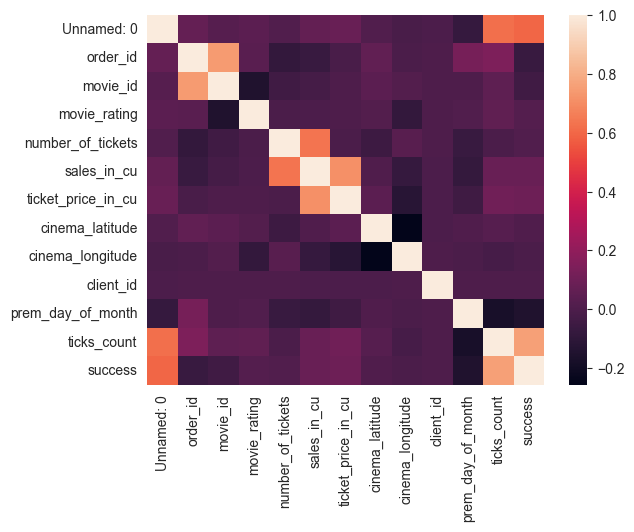

In [77]:
sns.heatmap(df.corr())

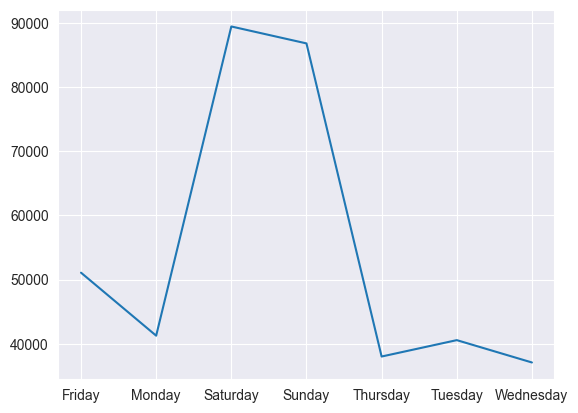

In [78]:
#кол-во купленных билетов до карантина
data = df[df['session_date']<='2020-03-25']
plt.plot(data.assign(dayofweek = lambda x: x['session_date'].dt.day_name()).groupby('dayofweek').count()['order_id'])

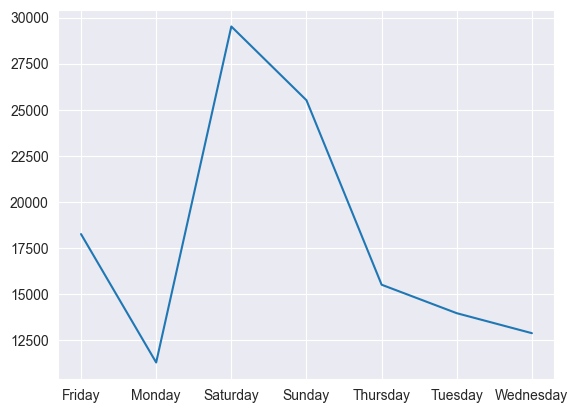

In [79]:
#кол-во купленных билетов после ослабления карантина
data = df[df['session_date']>'2020-07-31']
plt.plot(data.assign(dayofweek = lambda x: x['session_date'].dt.day_name()).groupby('dayofweek').count()['order_id'])

## Способы убрать выбросы

#### Был вариант убрать фильмы с маленьким рейтингом, количеству проданных билетов, но остановились на фильмах, выпущенных до 20-го года из-за наибольшей объективности способа(т.к. считаем по премьерам фильмов, до этого не имевших фанатов, рейтинг и т.п.)

<AxesSubplot: >

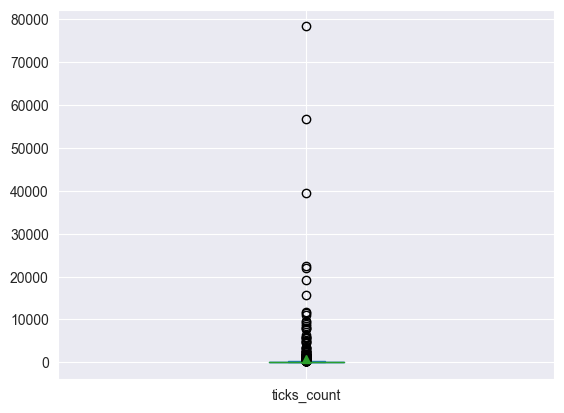

In [80]:
unique.ticks_count.plot.box(showmeans=True)

<AxesSubplot: >

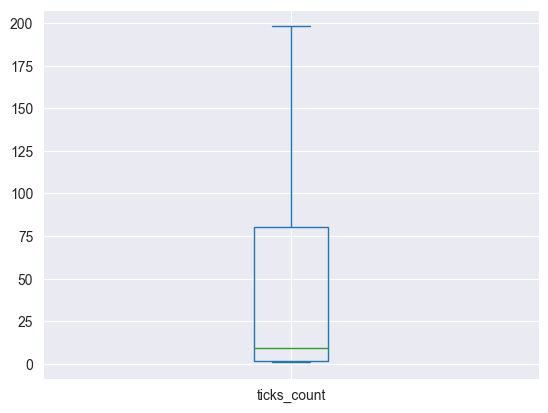

In [81]:
unique.ticks_count.plot.box(showfliers=0)

In [82]:
outs = df[df['success']<2]
outs

,Unnamed: 0,order_id,creation_date,session_date,movie_id,movie_name,movie_duration,movie_age_restriction,movie_rating,number_of_tickets,...,cinema_latitude,cinema_longitude,cinema_city,client_id,genre,prem_day,prem_day_of_month,premier_date,ticks_count,success
113278,755,2128334,2020-01-28,2020-01-28,22423,разум и искусство,75 мин.,16+,0.0,1,...,55.736312,37.594153,Москва,11996128770975600640,documentary,Tuesday,28,2020-01-28,1,1.0
133557,1099,2604605,2020-09-14,2020-09-16,50796,новое кино австрии революционеры в прошлом,104,18+,6.3,1,...,55.737252,37.609570,Москва,14917086973954899968,"drama, comedy",Wednesday,16,2020-09-16,1,1.0
232289,4966,2002208,2020-01-07,2020-01-07,8054,ван гог золото и лазурь,85,16+,0.0,1,...,55.028967,82.915077,Новосибирск,13797817087838599168,documentary,Tuesday,7,2020-01-07,4,1.0
232290,129701,2643405,2020-09-26,2020-09-26,101,ван гог золото и лазурь,85,16+,7.2,1,...,59.934452,30.339409,Санкт-Петербург,10819222251152300032,documentary,Tuesday,7,2020-01-07,4,1.0
232291,132169,1965595,2020-01-03,2020-01-07,101,ван гог золото и лазурь,85,16+,7.2,1,...,55.029054,82.914752,Новосибирск,14285273308343099392,documentary,Tuesday,7,2020-01-07,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511629,448519,2694610,2020-10-17,2020-10-17,57481,frem,73 мин.,18+,0.0,2,...,59.958185,30.316933,Санкт-Петербург,2965405464002270208,documentary,Saturday,17,2020-10-17,1,1.0
511632,474931,2661648,2020-10-03,2020-10-04,41491,nice мы будем юными и прекрасными,92,16+,6.2,2,...,55.029054,82.914752,Новосибирск,15684471759087099904,drama,Sunday,4,2020-10-04,1,1.0
511633,491531,2520370,2020-07-28,2020-07-28,47396,как женить холостяка,92 мин.,18+,0.0,2,...,44.584591,33.437689,Севастополь,12433266238938099712,",",Tuesday,28,2020-07-28,1,1.0
511634,506423,2667812,2020-10-05,2020-10-05,55780,ынми,71 мин.,18+,0.0,1,...,55.736312,37.594153,Москва,17277981309891299328,detective,Monday,5,2020-10-05,1,1.0


In [83]:
outs.groupby('movie_name').sum()['sales_in_cu'].sort_values(ascending=0)

movie_name
атлантика                          166.139241
хаббл                              166.139241
москва будто бы сон                166.139241
остров лемуров мадагаскар          166.139241
соло                               166.139241
                                      ...    
обыкновенный фашизм                 15.822785
государство против фрица бауэра     15.822785
пан т                               15.822785
пугало                              15.822785
ты и я                              15.822785
Name: sales_in_cu, Length: 185, dtype: float64

In [84]:
outs = df[df['ticks_count']<100]
outs

,Unnamed: 0,order_id,creation_date,session_date,movie_id,movie_name,movie_duration,movie_age_restriction,movie_rating,number_of_tickets,...,cinema_latitude,cinema_longitude,cinema_city,client_id,genre,prem_day,prem_day_of_month,premier_date,ticks_count,success
32092,255,2179536,2020-02-04,2020-02-05,26400,матиас и максим,120,18+,6.9,2,...,59.936304,30.342196,Санкт-Петербург,11448588293308801024,drama,Friday,3,2020-01-03,52,2.0
32093,1057,2235556,2020-02-12,2020-02-12,26400,матиас и максим,120,18+,6.9,1,...,55.753966,37.601627,Москва,13782816002485100544,drama,Friday,3,2020-01-03,52,2.0
32094,1963,2146791,2020-01-31,2020-01-31,26400,матиас и максим,120,18+,6.9,1,...,55.753966,37.601627,Москва,1070592623579960064,drama,Friday,3,2020-01-03,52,2.0
32095,2130,2041031,2020-01-12,2020-01-12,26400,матиас и максим,120,18+,6.9,1,...,59.936304,30.342196,Санкт-Петербург,6645245564864220160,drama,Friday,3,2020-01-03,52,2.0
32096,27275,2606593,2020-09-15,2020-09-19,26400,матиас и максим,120,18+,6.9,2,...,55.710687,37.675100,Москва,10457993961841700864,drama,Friday,3,2020-01-03,52,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511631,511288,2523437,2020-08-03,2020-08-12,48426,крестон,73,18+,6.5,2,...,55.727775,37.601591,Москва,4725132383543829504,documentary,Wednesday,12,2020-08-12,2,2.0
511632,474931,2661648,2020-10-03,2020-10-04,41491,nice мы будем юными и прекрасными,92,16+,6.2,2,...,55.029054,82.914752,Новосибирск,15684471759087099904,drama,Sunday,4,2020-10-04,1,1.0
511633,491531,2520370,2020-07-28,2020-07-28,47396,как женить холостяка,92 мин.,18+,0.0,2,...,44.584591,33.437689,Севастополь,12433266238938099712,",",Tuesday,28,2020-07-28,1,1.0
511634,506423,2667812,2020-10-05,2020-10-05,55780,ынми,71 мин.,18+,0.0,1,...,55.736312,37.594153,Москва,17277981309891299328,detective,Monday,5,2020-10-05,1,1.0


### Разделяем на датасет на фильмы премьера которых была в 20м году, и на те, которые вышли ранее 19-го года

In [85]:
films_20_year = films[films['year']==2020]
films_before_20_year = films[films['year']<2019]

In [86]:
gip1_df =df[df['movie_name'].isin(films_20_year['movie_name'])]
gip1_df = gip1_df[gip1_df['premier_date']+ pd.Timedelta(14,unit='D') >= gip1_df['session_date']]

In [87]:
gip2_df =df[df['movie_name'].isin(films_before_20_year['movie_name'])]
gip2_df = gip2_df[gip2_df['premier_date']+ pd.Timedelta(14,unit='D') >= gip2_df['session_date']]

In [88]:
#graphs for gif
# for n in tqdm(range(0,104,3)):
#     ts = df.groupby('movie_name').sum()['sales_in_cu'].sort_values(ascending=False)[:n]
#     data = df[~df['movie_name'].isin(ts.index)].groupby(['prem_day','success']).sum()['sales_in_cu'].reset_index()
#     fig = sns.barplot(data = data, x='prem_day',y=data['sales_in_cu'],hue='success',palette='viridis_r').get_figure()
#     plt.title(str(n))
#     plt.savefig(f'{n}.png')
#     plt.clf() 
# None

###  Первая гипотеза(Среда и четверг наиболее оптимальные дни для выпуска фильма в прокат)

<AxesSubplot: xlabel='prem_day', ylabel='sales_in_cu'>

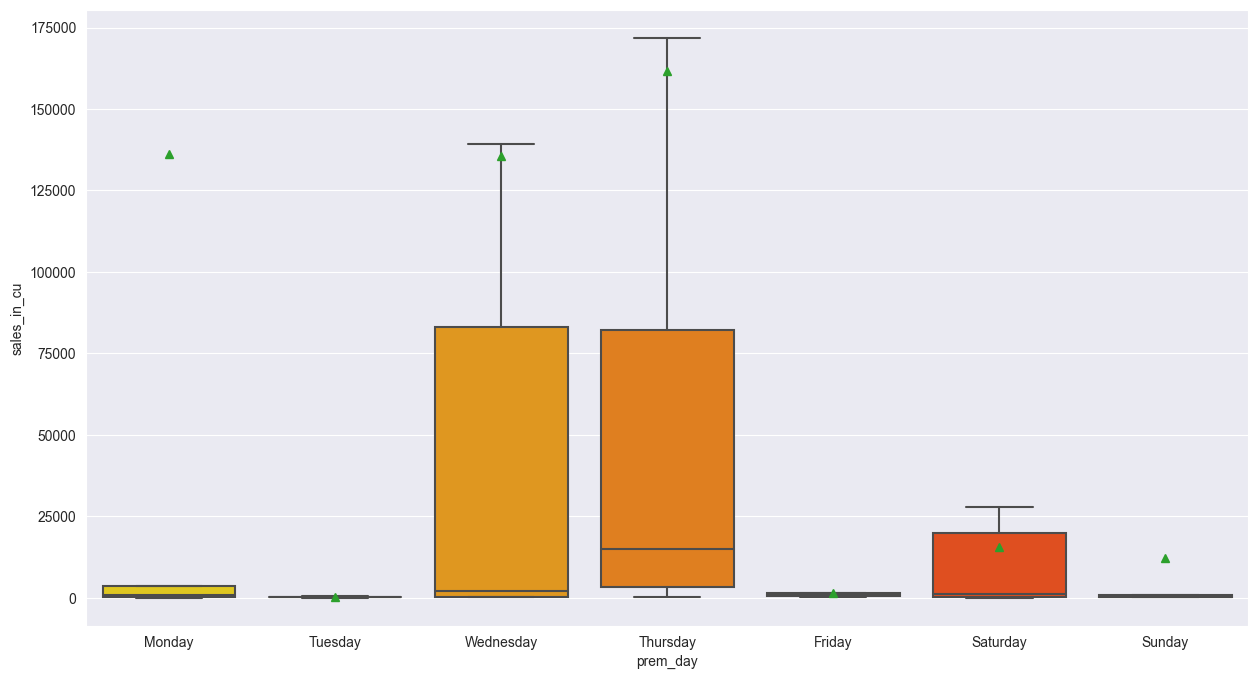

In [89]:
plt.figure(figsize=(15,8))
#sns.boxplot(data=df,x='prem_day',y='sales_in_cu',showmeans=1,showfliers=0)
sns.boxplot(data=gip1_df.groupby('movie_name').sum()['sales_in_cu'].reset_index().merge(
    unique[['prem_day','movie_name']],how='inner',on='movie_name'),
            x='prem_day',y='sales_in_cu',showfliers=0,showmeans=1, palette='autumn_r',
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

<AxesSubplot: xlabel='prem_day', ylabel='count'>

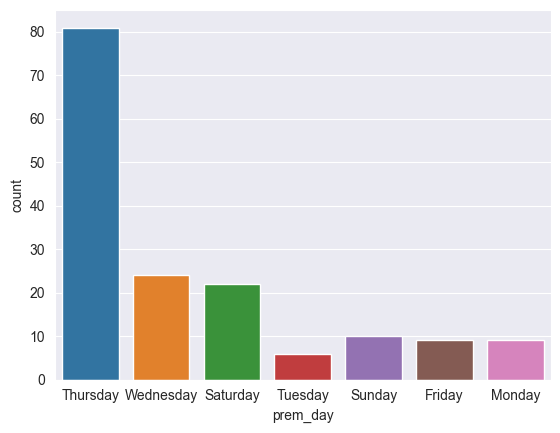

In [90]:
sns.countplot(data=gip1_df.drop_duplicates(subset='movie_name'), x='prem_day')

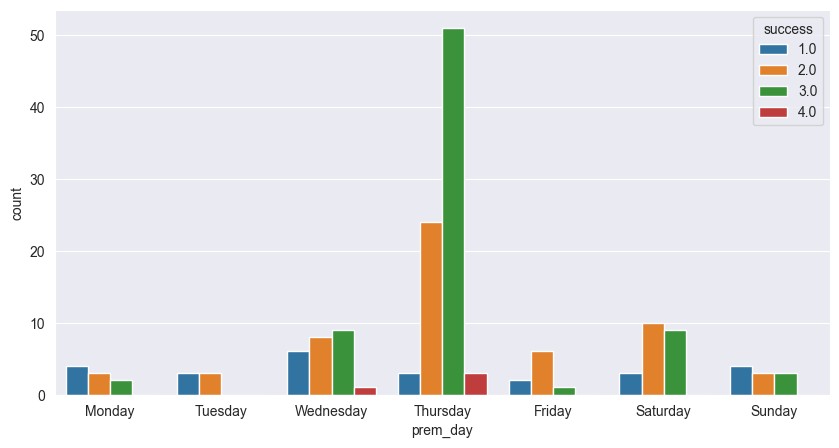

In [91]:
plt.figure(figsize=(10,5))
sns.countplot(data=gip1_df.drop_duplicates(subset='movie_name'),x='prem_day',hue='success',
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
None

In [136]:
gip1 =gip1_df.groupby('movie_name').sum()['sales_in_cu'].reset_index().merge(unique[['prem_day','movie_name']],how='inner',on='movie_name')
groupa = gip1[gip1['prem_day'].isin(['Thursday','Wednesday'])]['sales_in_cu']
groupb = gip1[~gip1['prem_day'].isin(['Thursday','Wednesday'])]['sales_in_cu']
pvalue_1 = stats.ttest_ind(groupa, groupb,equal_var=0,alternative='greater')[1]
print('p-value для первой гипотезы:',pvalue_1)
print('Не отклоняем нулевую гипотезу' if pvalue_1 > 0.05 else 'Отклоняем нулевую гипотезу')

p-value для первой гипотезы: 0.023000013389092445
Отклоняем нулевую гипотезу


In [93]:
#Среда - оптимальный день(хиквадрат тест)
data = gip1_df.drop_duplicates(subset='movie_name')
data['prem_day'] = data['prem_day'].map(
    {'Friday':0,'Wednesday':1, 'Thursday':0,'Monday':0,'Saturday':0,'Sunday':0,'Tuesday':0})
data[['prem_day','success']].to_csv('gip1_1.csv')

In [94]:
#Четверг - оптимальный день(хиквадрат тест)
data = gip1_df.drop_duplicates(subset='movie_name')
data['prem_day'] = data['prem_day'].map(
    {'Friday':0,'Wednesday':0, 'Thursday':1,'Monday':0,'Saturday':0,'Sunday':0,'Tuesday':0})
data[['prem_day','success']].to_csv('gip1_2.csv')

### Вторая гипотеза 2 вариант(день недели премьеры фильма вновь выпущенного в прокат также влияет на сборы)

<AxesSubplot: xlabel='prem_day', ylabel='count'>

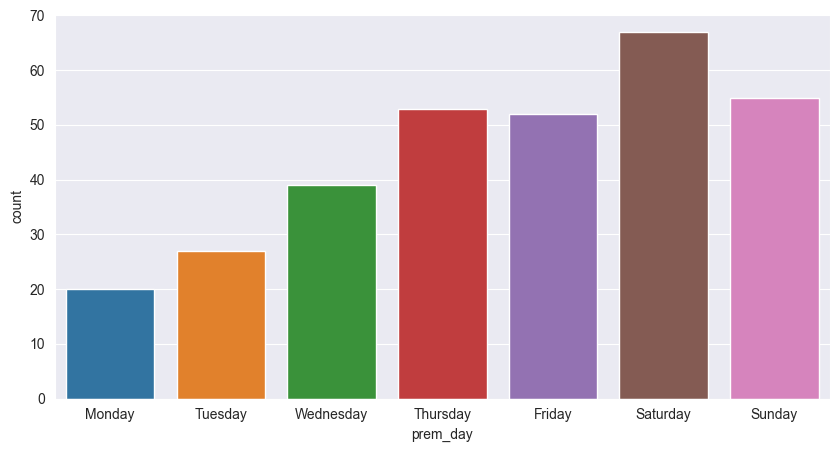

In [95]:
plt.figure(figsize=(10,5))
sns.countplot(data=gip2_df.drop_duplicates(subset='movie_name'), x='prem_day',
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

<AxesSubplot: xlabel='prem_day', ylabel='sales_in_cu'>

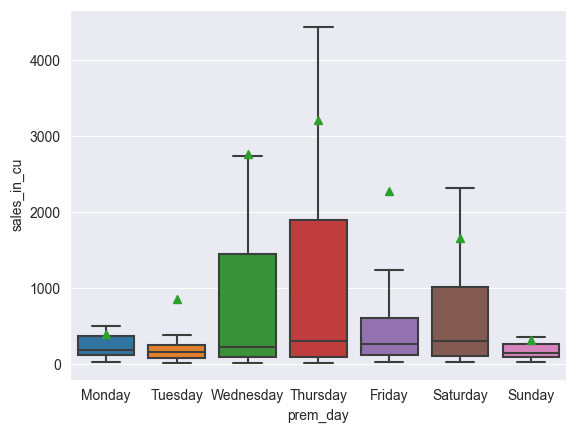

In [96]:
## plt.figure(figsize=(10,5))
sns.boxplot(data=gip2_df.groupby('movie_name').sum()['sales_in_cu'].reset_index().merge(
    unique[['prem_day','movie_name']],how='inner',on='movie_name'),x='prem_day',y='sales_in_cu',showmeans=1,showfliers=0,
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

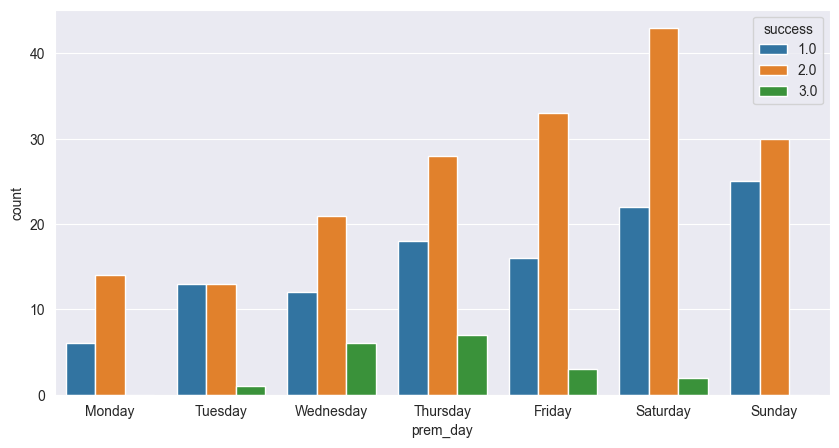

In [97]:
plt.figure(figsize=(10,5))
sns.countplot(data=gip2_df.drop_duplicates(subset='movie_name'),x='prem_day',hue='success',
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
None

In [139]:
data = gip2_df.groupby('movie_name').sum()['sales_in_cu'].reset_index().merge(
    unique[['prem_day','movie_name']],how='inner',on='movie_name')
data = pd.DataFrame({
    'Monday': data[data['prem_day']=='Monday']['sales_in_cu'],
    'Tuesday': data[data['prem_day']=='Tuesday']['sales_in_cu'],
    'Wednesday': data[data['prem_day']=='Wednesday']['sales_in_cu'],
    'Thursday': data[data['prem_day']=='Thursday']['sales_in_cu'],
    'Friday': data[data['prem_day']=='Friday']['sales_in_cu'],
    'Saturday': data[data['prem_day']=='Saturday']['sales_in_cu'],
    'Sunday': data[data['prem_day']=='Sunday']['sales_in_cu'],
})

data['Monday'] = data['Monday'].fillna(data['Monday'].median())
data['Tuesday'] = data['Tuesday'].fillna(data['Tuesday'].median())
data['Wednesday'] = data['Wednesday'].fillna(data['Wednesday'].median())
data['Thursday'] = data['Thursday'].fillna(data['Thursday'].median())
data['Friday'] = data['Friday'].fillna(data['Friday'].median())
data['Saturday'] = data['Saturday'].fillna(data['Saturday'].median())
data['Sunday'] = data['Sunday'].fillna(data['Sunday'].median())

print('Нулевая гипотеза:', '='.join(data))
print('Альтернативная гипотеза:', f'!({"=".join(data)})')
# общая средняя
grand_mean = data.values.flatten().mean()
# отклонение групповых средний от общей средней
ssb = sum(data[group].size * (group_mean - grand_mean)**2  for group, group_mean in data.mean().items())
# отклонения значений в внутри группы от средней группы
ssw = sum(sum((x - group_mean)**2 for x in data[group]) for group, group_mean in data.mean().items())

groups = data.shape[1]
dfb = groups - 1
dfw = data.size - groups
# межгрупповой средний квадрат  
mssb = ssb/dfb
# внутригрупповой средний квадрат
mssw = ssw/dfw

f_value = mssb/mssw

p = stats.f.sf(f_value, dfb, dfw)
print('Результат:')
if p < 0.05:
    print('отклоняем нулевую гипотезу')
else:
    print('НЕ отклоняем нулевую гипотезу')

Нулевая гипотеза: Monday=Tuesday=Wednesday=Thursday=Friday=Saturday=Sunday
Альтернативная гипотеза: !(Monday=Tuesday=Wednesday=Thursday=Friday=Saturday=Sunday)
Результат:
отклоняем нулевую гипотезу


In [140]:
gip2 =gip2_df.groupby('movie_name').sum()['sales_in_cu'].reset_index().merge(unique[['prem_day','movie_name']],how='inner',on='movie_name')
groupa = gip2[gip2['prem_day'].isin(['Thursday','Friday'])]['sales_in_cu']
groupb = gip2[~gip2['prem_day'].isin(['Thursday','Friday'])]['sales_in_cu']
pvalue_1 = stats.ttest_ind(groupa, groupb,equal_var=0,alternative='greater')[1]
print('p-value для второй гипотезы:',pvalue_1)
print('Не отклоняем нулевую гипотезу' if pvalue_1 > 0.05 else 'Отклоняем нулевую гипотезу')

p-value для второй гипотезы: 0.047989693467879055
Отклоняем нулевую гипотезу


In [ ]:
#Среда - оптимальный день(хиквадрат тест)
data = gip2_df.drop_duplicates(subset='movie_name')
data['prem_day'] = data['prem_day'].map(
    {'Friday':0,'Wednesday':1, 'Thursday':0,'Monday':0,'Saturday':0,'Sunday':0,'Tuesday':0})
data[['prem_day','success']].to_csv('gip2_1.csv')

In [ ]:
#Четверг - оптимальный день(хиквадрат тест)
data = gip2_df.drop_duplicates(subset='movie_name')
data['prem_day'] = data['prem_day'].map(
    {'Friday':0,'Wednesday':0, 'Thursday':1,'Monday':0,'Saturday':0,'Sunday':0,'Tuesday':0})
data[['prem_day','success']].to_csv('gip2_2.csv')

In [ ]:
#Суббота - оптимальный день(хиквадрат тест)
data = gip2_df.drop_duplicates(subset='movie_name')
data['prem_day'] = data['prem_day'].map(
    {'Friday':0,'Wednesday':0, 'Thursday':0,'Monday':0,'Saturday':1,'Sunday':0,'Tuesday':0})
data[['prem_day','success']].to_csv('gip2_3.csv')